In [1]:
using Polynomials
push!(LOAD_PATH, pwd())
using Controlz
using Test
using PyPlot
using DifferentialEquations
using Logging

In [18]:
function simulate(tf::TransferFunction, u::Function, tspan::Tuple{Float64, Float64};
        nb_time_points::Int=100)
    if ! proper(tf)
        error("transfer function not proper...")
    end
    # TODO implement time delays
    if tf.time_delay != 0.0
        error("time delay not implemented yet")
    end
    
    a_i(i::Int) = tf.denominator[i]
    b_i(i::Int) = tf.numerator[i]
    n = degree(tf.denominator)
    
    # convert tf to state space form
    A, B, C = Controlz.tf_to_ss(tf)
    
    x0 = zeros(n, 1) # initial condition
    
    f(x, p, t) = A * x + B * u(t) # RHS of ODE (ignore p for params)
    prob = ODEProblem(f, x0, tspan)
    sol = solve(prob)
    
    t = range(tspan[1], stop=tspan[2], length=nb_time_points)
    y = [NaN for i = 1:nb_time_points]
    for (i, t_i) in enumerate(t)
        y[i] = (C * sol(t_i))[1] + b_i(n) / a_i(n) * u(t_i)
    end
    return t, y
end

tf = 2 / (3 * s + 1)
tspan = (0.0, 12.0)
u(t) = t < 0.0 ? 0.0 : 1.0
t, y = simulate(tf, u, tspan, nb_time_points=100)

(0.0:0.12121212121212122:12.0, [0.0, 0.07919736053425332, 0.15525861488945147, 0.2283079339324153, 0.29846461345984515, 0.3658432320334914, 0.43055367786012144, 0.49270162994720224, 0.5523886363620103, 0.6097122117849327  …  1.9473093175948804, 1.9493934831964295, 1.9513949404710857, 1.9533171485642635, 1.9551634444123014, 1.9569370427424628, 1.958641036072935, 1.9602783911281778, 1.9618513144305816, 1.963361952012428])

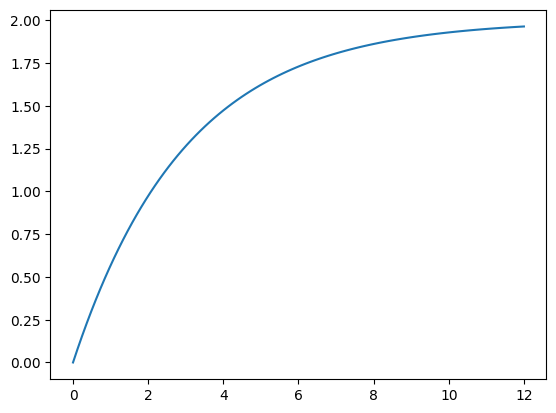

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f334a76f0f0>

In [19]:
figure()
plot(t, y)

In [5]:
y

1-element Array{Float64,1}:
 0.0

In [6]:
u(t) = 3.0

tspan = (0.0, 1.0)


(0.0, 1.0)

In [7]:
typeof(tspan)

Tuple{Float64,Float64}

In [8]:
sol.u

UndefVarError: UndefVarError: sol not defined

In [9]:
    tf = 1 / (2 * s + 1)
    @assert proper(tf)
    @assert strictly_proper(tf)
    tf = 3 * s / (2 * s + 1)
    @assert proper(tf)
    @assert ! strictly_proper(tf)
    tf = (3 * s * s) / (2 * s + 1)
    @assert ! proper(tf)
    @assert ! strictly_proper(tf)


In [10]:
tf = 3 * s / (2 * s + 1)

   3.0*s
-----------
2.0*s + 1.0

In [11]:
proper(tf)

true

In [12]:
strictly_proper(tf)

false